In [33]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
from io import StringIO
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
# great library sourcing here...
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz, _tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from logitboost import LogitBoost
from sklearn import svm

import imodels
import sys
#sys.path.append('../../../../')
from rulevetting.api import validation
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn.graph import barplot

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output
data_path = '../../../../data/' # path to raw csv - change to processed...

# default plotting properties - has to be an easier way then doing this every notebook
TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18
fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# what is the purpose of this cell with the bottom one also? - probably delete this later on
df = Dataset().clean_data(data_path = data_path)
df = Dataset().preprocess_data(df)
df_train, df_tune, _ = Dataset().split_data(df)
X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()
feature_names = list(X_train)


def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.43it/s]
/Users/sahilsaxena/rule-env/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
simple_var_list = ['InjuryMech_Assault',
       'InjuryMech_Bicyclist struck by automobile',
       'InjuryMech_Bike collision/fall', 'InjuryMech_Fall down stairs',
       'InjuryMech_Fall from an elevation',
       'InjuryMech_Fall to ground standing/walking/running',
       'InjuryMech_Motor vehicle collision',
       'InjuryMech_Object struck head - accidental',
       'InjuryMech_Other mechanism', 'InjuryMech_Other wheeled crash',
       'InjuryMech_Pedestrian struck by moving vehicle', 'InjuryMech_Sports',
       'InjuryMech_Walked/ran into stationary object',
       'High_impact_InjSev_High', 'High_impact_InjSev_Low',
       'High_impact_InjSev_Moderate', 'Amnesia_verb_No', 
       'Amnesia_verb_Pre/Non-verbal', 'Amnesia_verb_Yes',
       'LOCSeparate_No', 'LOCSeparate_Suspected', 'LOCSeparate_Yes', 
       'Seiz', 'ActNorm', 'HA_verb_No', 'HA_verb_Pre/Non-verbal', 'HA_verb_Yes',
        'Vomit', 'Intubated', 'Paralyzed', 'Sedated',
       'GCSTotal', 'GCSGroup', 'AMS', 'SFxPalp_No', 'SFxPalp_Unclear', 'SFxPalp_Yes',
       'FontBulg', 'Hema', 'Clav', 'NeuroD', 'OSI', 'Drugs', 'AgeTwoPlus', 'Gender', 'outcome']

df_simp = df[simple_var_list]

# Excluding samples with GCS score < 14 and dropping GCSGroup indicator
df_simp = df_simp[df_simp['GCSTotal'] >= 14]
df_simp = df_simp.drop(columns=["GCSGroup"])

# splits for simplified data 
df_simp_train, df_simp_tune, df_simp_test = Dataset().split_data(df_simp)
X_simp_train = df_simp_train.drop(columns=outcome_def)
y_simp_train = df_simp_train[outcome_def].values
X_simp_tune = df_simp_tune.drop(columns=outcome_def)
y_simp_tune = df_simp_tune[outcome_def].values
X_simp_test = df_simp_test.drop(columns=outcome_def)
y_simp_test = df_simp_test[outcome_def].values
processed_feats_simp = df_simp_train.keys().values.tolist()
feature_names_simp = list(X_simp_train)

In [57]:
len(feature_names_simp)

44

In [31]:
# SANITY CHECK
train_positive_prop = sum(y_simp_train == 1) / len(y_simp_train)
tune_positive_prop = sum(y_simp_tune == 1) / len(y_simp_tune)
test_positive_prop = sum(y_simp_test == 1) / len(y_simp_test)

train_positive_prop, tune_positive_prop, test_positive_prop

(0.009113048943357687, 0.009898656610888523, 0.007070469007777516)

# SVM, with RBF kernal

### Now fitting initial svm, with C = 1


In [41]:
svm_model = svm.SVC(probability=True)
svm_model.fit(X_simp_train, y_simp_train)
print("Train Accuracy:", svm_model.score(X_simp_train, y_simp_train))
print("Train AUC:", roc_auc_score(y_simp_train, svm_model.predict_proba(X_simp_train)[:, 1]))

Train Accuracy: 0.9908869510566423
Train AUC: 0.7874328996902484


### Tuning SVM

In [42]:
roc_tune = []
acc_tune = []
for c in [2**(-3), 2**(-2), 2**(-1), 1, 2**(1), 2**(2), 2**(3)]:
    svm_v = svm.SVC(C = c, probability=True).fit(X_simp_train, y_simp_train)
    roc_tune.append(roc_auc_score(y_simp_tune, svm_v.predict_proba(X_simp_tune)[:, 1]))
    acc_tune.append(svm_v.score(X_simp_tune, y_simp_tune))

print("Validation AUC:", np.around(roc_tune, 5))
print("Validation ACC:", np.around(acc_tune, 5))

Validation AUC: [0.51614 0.62391 0.64218 0.59263 0.55546 0.54416 0.53203]
Validation ACC: [0.9901 0.9901 0.9901 0.9901 0.9901 0.9901 0.9901]


### More tuning

In [43]:
roc_tune2 = []
acc_tune2 = []
for c in [2**(-1.75), 2**(-1.5), 2**(-1.25), 2**(-0.75), 2**(-0.5)]:
    svm_v = svm.SVC(C = c, probability=True).fit(X_simp_train, y_simp_train)
    roc_tune2.append(roc_auc_score(y_simp_tune, svm_v.predict_proba(X_simp_tune)[:, 1]))
    acc_tune2.append(svm_v.score(X_simp_tune, y_simp_tune))

print("Validation AUC:", np.around(roc_tune2, 5))
print("Validation ACC:", np.around(acc_tune2, 5))

Validation AUC: [0.532   0.49252 0.68277 0.60565 0.56346]
Validation ACC: [0.9901 0.9901 0.9901 0.9901 0.9901]


### Final SVM Model, C = 1

Test AUC: 0.5750563731307856
Test ACC: 0.9929295309922225


100%|█████████████████████████████████████████████████████████████| 3355/3355 [00:03<00:00, 907.91it/s]


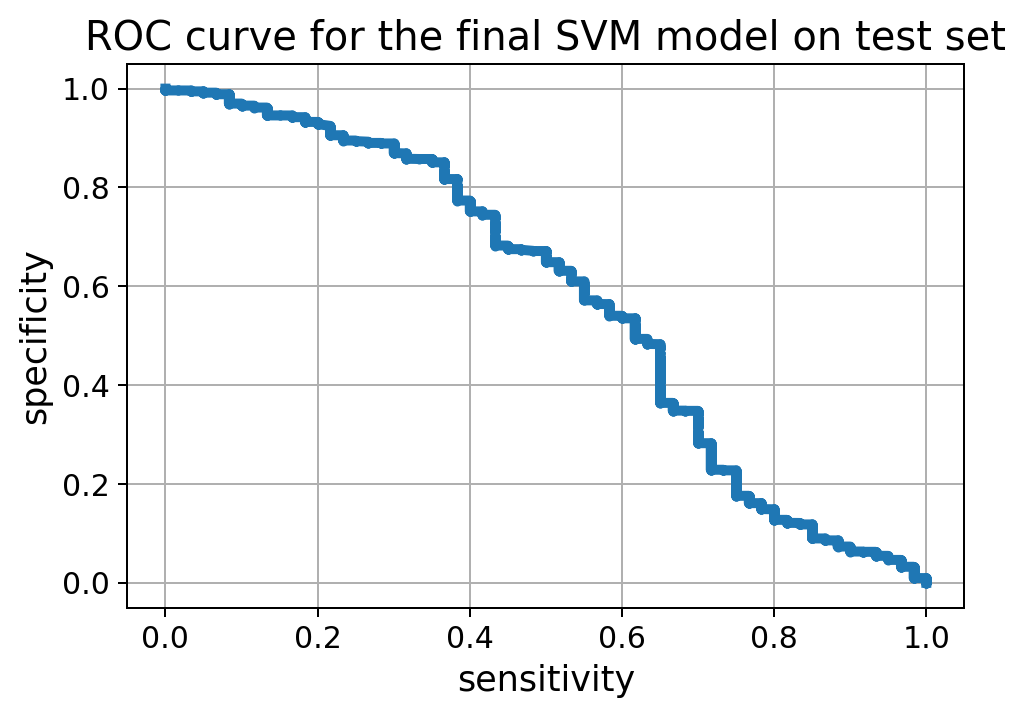

In [50]:
svm_final = svm.SVC(C = 1, probability=True).fit(pd.concat([X_simp_train, X_simp_tune], axis = 0), 
                                                                                      np.hstack((y_simp_train, y_simp_tune)))
print("Test AUC:", roc_auc_score(y_simp_test, svm_final.predict_proba(X_simp_test)[:, 1])) 
print("Test ACC:", svm_final.score(X_simp_test, y_simp_test))

# Plot the result for the test set
validation.all_stats_curve(y_simp_test, svm_final.predict_proba(X_simp_test)[:, 1], plot = True)
plt.title('ROC curve for the final SVM model on test set')
plt.show()